# Practical 01: EEG data analysis

In [1]:
# Credits: this notebook was written by Ilaria Gavetti for the Cognitive Neuroscience EEG practical & EEGlab.

# MNE-toolbox was used as reference to develop and implement the code. 

**PLASE ADD HERE BELOW THE NAMES AND U-NUMBERS OF ALL THE PEOPLE IN YOUR GROUP WHO PARTICIPATED IN THE PRACTICAL**


In [2]:
# NAMES AND U-NUMBERS HERE:




! pip install mne

In [1]:
import mne
import os
import numpy as np
import csv
import pandas as pd

Welcome to the data-analysis part of the EEG pracical. At this point, you should have:

1. collected your data 
2. received an output csv file from the data collection procedure, one for each condition, for instance: Open_eyes_1.csv, Open_eyes_2.csv, Closed_eyes_1.csv, Closed_eyes_2.csv.


Follow the instructions below to properly upload and conduct your data-analysis:

# Step 0: upload the files

First, I suggest creating a "base" directory, called "EEG practical".

Then, please upload all the .csv files from your laptop in the directory **"/.../EEG_practical/1. Raw files"**, where the **"..."** part is your personal path to get to **"EEG_practical"** and **1. Raw files** is a folder in this directory which you should manually add.

Also, since we will be saving intermediate files during the analysis, add the following folders to your **"EEG_practical"** directory:

**2. Loading & Digitization**

**3. ICA**

**4. Epoch** (with inside other 3 folders called **Annotations**, **Closed** and **Open**)

**5. TFR**

The code you will run already has these directories implemented.

Last, but not least, change your current working directory to **"EEG_practical"** if it's not already set to it, to ensure the code runs smoothly.

In [2]:
os.getcwd()

'/home/jovyan/NEW (22-23)/Student Assistant/CogNeuro re-design/EEG practical '

In [ ]:
os.chdir("/.../EEG practical") # add your own path in the "..." part if your current working directory is not already the EEG practical folder.

# Steps 1&2: Loading: you might have to troubleshoot a bit with the code to adjust the directories from your enviroment, so don't worry if you get some errors about that at the beginning.

# For .csv extension 

In [ ]:
# Read the CSV file as a NumPy array

for file in os.listdir("1. Raw files"):
    if "csv" in file:
        data = pd.read_csv("1. Raw files/"+file, delimiter=",", verbose = True)
        data_sub = data[["EEG 1", "EEG 2", "EEG 3", "EEG 4", "EEG 5", "EEG 6", "EEG 7", "EEG 8"]] # only select the elecrodes columns, not the rest
        
        # Print file name
        print("****"+file+"****")
        
        # Some information about the channels
        ch_names_new = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"] # from Unicorn BCI manual

        # Sampling rate of the Unicorn BCI
        sfreq = 250  # Hz

        # Create the info structure needed by MNE
        info = mne.create_info(ch_names_new, sfreq, ch_types = ["eeg"]*len(ch_names_new), verbose = True)
        
        # Set montage       
        info.set_montage(montage = 'standard_1020')
        
        # Finally, create the Raw object
        raw = mne.io.RawArray(data_sub.T, info, verbose = True)
        
        # Filter 
        
        raw.filter(1,30)
        
        # Sett EEG reference
        raw.set_eeg_reference()
        
        
        # Plot it!
        raw.plot(scalings="auto", duration = 2)
        
        # Save it!
        if "Open" in file: # open and closed csv files have different lenghts, so by doing this we ensure the names of the new files will be correct
            raw.save("2. Loading & Digitization/"+file[0:11]+"_raw.fif", overwrite = True)
        else:
            raw.save("2. Loading & Digitization/"+file[0:13]+"_raw.fif", overwrite = True)
            

# For .vhdr extension - skip this 

In [ ]:
for eo_vhdr_file in os.listdir("1. Raw files"):
    if "Open" in eo_vhdr_file:
        sample_data_raw_file = ("1. Raw files/"+eo_vhdr_file)
        raw = mne.io.read_raw_brainvision(sample_data_raw_file)
        raw.plot_psd(fmax=50, verbose = False)
        raw.save("2. Loading & Digitization/"+file[0:11]+"_raw.fif")

In [ ]:
for ec_vhdr_file in os.listdir("1. Raw files"):
    if "Closed" in ec_vhdr_file:
        sample_data_raw_file = ("1. Raw files/"+ec_vhdr_file)
        raw = mne.io.read_raw_brainvision(sample_data_raw_file)
        raw.plot_psd(fmax=50, verbose = False)
        raw.save("2. Loading & Digitization/"+file[0:13]+"_raw.fif")

# Step 3: artifcats rejection

Artifacts rejection is an important step in the EEG data analysis process: it allows to remove unwanted noise in the signal, possibly caused by (among others):

1. eye blinks
2. saccades
3. muscle twitches
4. noise in the enviroment
5. electrical signal sources in proximity (i.e., laptops, EEG hardware etc.)

For this tutorial, we will focus on eye blinks and saccades, the two most prominent artifacts.

It's important to know that the existing algorithms that are meant to target and remove these type of artifacts are great, but occasionally still report False Negatives (an artifact is classified as clean signal) as well as Flase Positives (a clean signal is classified as artifcat).

Run the following code to perofrm automatic eye artifacts rejection:


In [4]:
from ica_function import ica_visualization 

path_to_dig_file = ["2. Loading & Digitization"] # define the path to the digitized file

In [ ]:
for i in range(len(path_to_dig_file)): 
    files_list = os.listdir(path_to_dig_file[i]) 
    for filename in files_list: # for file in files_list
        if "raw" in filename: # if this file has been digitized
            ica_visualization(filename, path_to_dig_file[i]) # run automatic ICA rejection

# Step 4: Adding annotations manually

Up until now, the raw data does not contain any markers, meaning that each file is a continuous flow of EEG data without any marker indicating where the open_eyes and closed_eyes trials happen.

That is normal, since we recorded the two conditions over the whole file, not at specific times during the recording.

Nevertheless, it is better to split the whole EEG recording into smaller parts. For example, since each recording lasts 60 seconds, we could split it into 12 sub-parts of 5 seconds each, and tell the code that each of those 12 sub-parts marks the beginning of a 5-seconds long open/closed_eyes trial, depending on the file.

This will allow us to  "Epoch" the data, which will make our life easier later in the notebook!



In [6]:
os.getcwd()

'/home/jovyan/NEW (22-23)/Student Assistant/CogNeuro re-design/EEG practical '

In [7]:
files_open_eyes = os.listdir("3. ICA") # path to where the ICA files are stored

In [ ]:
for file_open in files_open_eyes:
    if "Open" in file_open:
        sample_data_raw_file = "3. ICA/"+file_open
        raw_open_eyes = mne.io.read_raw_fif(sample_data_raw_file, preload= True)

        # Annotation 

        my_annot_open = mne.Annotations(onset=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55],  # in seconds
                               duration=[5,5,5,5,5,5,5,5,5,5,5,5],  # in seconds, too
                               description=['eye_open', 'eye_open', 'eye_open','eye_open','eye_open', 'eye_open','eye_open', 'eye_open', 'eye_open','eye_open','eye_open','eye_open' ])
        print(my_annot_open)


        # Adding markers

        raw_open_eyes.set_annotations(my_annot_open)
        print(raw_open_eyes.annotations)

        # convert meas_date (a tuple of seconds, microseconds) into a float:
        meas_date = raw_open_eyes.info['meas_date']
        orig_time = raw_open_eyes.annotations.orig_time
        print(meas_date == orig_time)

        fig = raw_open_eyes.plot_psd(fmax = 40)

        raw_open_eyes.save("4. Epoch/Annotations/"+file_open[0:11]+"_annot_raw.fif", overwrite = True)
    
    

In [9]:
files_closed_eyes = os.listdir("3. ICA") # path to where the ICA files are stored

In [ ]:
for file_closed in files_closed_eyes:
    if "Closed" in file_closed:
        sample_data_raw_file = "3. ICA/"+file_closed
        raw_closed_eyes = mne.io.read_raw_fif(sample_data_raw_file, preload= True)

        # Annotation 

        my_annot_closed = mne.Annotations(onset=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55],  # in seconds
                               duration=[5,5,5,5,5,5,5,5,5,5,5,5],  # in seconds, too
                               description=['eye_closed', 'eye_closed', 'eye_closed','eye_closed','eye_closed', 'eye_closed','eye_closed', 'eye_closed', 'eye_closed','eye_closed','eye_closed','eye_closed' ])
        print(my_annot_closed)


        # Adding markers

        raw_closed_eyes.set_annotations(my_annot_closed)
        print(raw_closed_eyes.annotations)

        # convert meas_date (a tuple of seconds, microseconds) into a float:
        meas_date = raw_closed_eyes.info['meas_date']
        orig_time = raw_closed_eyes.annotations.orig_time
        print(meas_date == orig_time)

        fig = raw_closed_eyes.plot_psd(fmax = 40)

        raw_closed_eyes.save("4. Epoch/Annotations/"+file_closed[0:13]+"_annot_raw.fif", overwrite = True)
        
        

# Step 5: epoching

In [11]:
from Epoching import epoching

First of all, you're doing great! Congratulations for getting this far, we are almost there!

In the next step, epoching, you will "epoch" your files: this means that the program will take each file and extract the 5-seconds long trials marked by the markers we inserted in the Annotations step and save this information in a new, "Epoch" file, which can be thought of as a N-dimensional numpy array of shape: trials(the amount of markers we inserted in the Annotations step) X nr_channels X time points.

In [12]:
os.getcwd()

'/home/jovyan/NEW (22-23)/Student Assistant/CogNeuro re-design/EEG practical '

In [ ]:
for file in os.listdir("4. Epoch/Annotations"):
    if "raw" in file:
        epoching(file, "4. Epoch/Annotations")

# Load two of the files you epoched to make sure the time ranges are correct: the files should report: t = -1000.00....5000ms >> from -1 to 5 seconds.

In [ ]:
epoch_EO = mne.read_epochs("4. Epoch/Open/Open_Eyes_2-open_eyes_epo.fif", preload= True)

**Check the shape of the epoch by converting it into an array:**

In [ ]:
epoch_EO.get_data().shape

We have 8 channels and 1501 time points in the epoch. The first dimension (the number of trial markers) could be either 12 (11 in the epoch, since index starts at 0 in array) or slightly less, since during th epoching process, the function might have dropped a few "bad epochs".

In [ ]:
epoch_EC = mne.read_epochs("4. Epoch/Closed/Closed_Eyes_2-closed_eyes_epo.fif", preload= True)

**Same for this epoch:**

In [ ]:
epoch_EC.get_data().shape

# Step 6: power spectra

Let's visualise the power spectra of the two loaded epoched files, just to see if there is any difference between the two conditions.
Can you see any difference between the two plots? Does one condition report larger/smaller values than the other and if so, in what frequency range?
The dottend vertical lines that you see in the plots represent the frequency range (1-30 Hz) that we are interested in.

In [ ]:
epoch_EO.compute_psd().plot(picks='eeg')

In [ ]:
epoch_EC.compute_psd().plot(picks='eeg')

# Step 7: TFR visualization

In [98]:
from TFR import tfr_analysis
from matplotlib import colors
import matplotlib.pyplot as plt

And now, the last step: time-frequency visualization.

In this last step, we will work with the two epoched groups of files, open vs closed.

What we want to do is, extracting and visualising the *"temporal evolution of spectral properties of the signal"* (https://link.springer.com/referenceworkentry/10.1007/978-1-4614-6675-8_421).

In order to do so, you should get familiar with the concept of the **"Fourier Transofrm"**: this is a process that, by fitting sinusoidal waves of different frequncies to your cleaned and epoched EEG signal, it extracts the "similarity" of the signal to these different sine waves, transposing the singal to a time-frequncy representation. The signal can then be visualised on the time domain (the time window you set during the epoching) and a frequncy range (what frequency range are we interested in? In this case, alpha range > 8-12).

This means that, for the epoched files, we would like to explore (in our case) the alpha porperties for the  corresponding signals at certain channels, over time.

Alpha waves are known to inhibit areas of the cortex not in use (i.e., occipital areas when eyes are closed) (first observed by Berger, H. in 1929), therefore, the expectation is that, in the "closed eyes" condition, alpha waves will be stronger (innhibiting the occiptal lobe) compared to the "open eyes" condition.

Acess the link below to see an animaiton of the Fourier Transofrmaiton:
    
*Source for animation*: https://commons.wikimedia.org/wiki/File:Fourier_transform_time_and_frequency_domains.gif

In [99]:
channels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"] 

In [100]:
min_list = []
max_list = []

sd_min_list = []
sd_max_list = []

In [ ]:
freq_ranges = ["Alpha"]
times = np.linspace(start = 0, stop = 5, num = 151) # tmax equals 5 seconds 


for iChan in range(len(channels)): 
          
    info_list_fr = [4] # range between fmin and fmax 
    info_list_fmin = [8] # fmin Alpha
    info_list_fmax = [12] # fmax Alpha 
    

    for iBand in range(len(freq_ranges)): # len = 1
                
        freq_range, fmin, fmax = info_list_fr[iBand], info_list_fmin[iBand], info_list_fmax[iBand]
        freqs = np.arange(fmin, fmax, 1.) 
                  
              
        # Participant 1
            
        files =  tfr_analysis(["Open_Eyes_1-open_eyes_epo.fif", "Open_Eyes_2-open_eyes_epo.fif" ], ["Closed_Eyes_1-closed_eyes_epo.fif", "Closed_Eyes_2-closed_eyes_epo.fif"], "4. Epoch/Open", "4. Epoch/Closed", 2, freq_range, fmin, fmax, channels[iChan]) # call to funciton tfr_analysis
          
            
        final_to_plot_open = files[0]
        final_to_plot_closed = files[1]

        p_open = final_to_plot_open[iChan]
        p_closed = final_to_plot_closed[iChan]
        
        # Take the log
        
        p_open = np.log(p_open)
        p_closed = np.log(p_closed)

        # Extract min/max values for colorbar ranges:
                
        max_list.append(np.amax(p_open))
        max_list.append(np.amax(p_closed))
        min_list.append(np.amin(p_open))
        min_list.append(np.amin(p_closed))
        
        sd_max_list.append(np.amax(p_open-p_closed))
        sd_min_list.append(np.amin(p_open-p_closed))
          
        # Final lists
        p_open_list = [p_open]
        p_closed_list = [p_closed]
        p_spec_diff_list = [p_open-p_closed]
                 
    

# Sort the lists:

In [102]:
min_list.sort()
max_list.sort()

sd_min_list.sort()
sd_max_list.sort()

# From each of them, extract the 25th (for the min value) and the 75th (for the max value) percentiles:

In [103]:
vmin= np.percentile(min_list, 25)
vmax= np.percentile(max_list, 75)

vmin_sd= np.percentile(sd_min_list, 25)
vmax_sd= np.percentile(sd_max_list, 75)

# Run the code again, this time with vmin, vmax etc... already pre-set:

In [ ]:
freq_ranges = ["Alpha"]
times = np.linspace(start = 0, stop = 5, num = 151) # tmax equals 5 seconds 


# PLOTTING:

for iChan in range(len(channels)): 
    
    print("Visualising channel {}".format(channels[iChan]))
          
    info_list_fr = [4] # range between fmin and fmax 
    info_list_fmin = [8] # fmin Alpha
    info_list_fmax = [12] # fmax Alpha 
    

    for iBand in range(len(freq_ranges)): # len = 1
                
        freq_range, fmin, fmax = info_list_fr[iBand], info_list_fmin[iBand], info_list_fmax[iBand]
        freqs = np.arange(fmin, fmax, 1.) 
                  
              
        # Participant 1
            
        files =  tfr_analysis(["Open_Eyes_1-open_eyes_epo.fif", "Open_Eyes_2-open_eyes_epo.fif" ], ["Closed_Eyes_1-closed_eyes_epo.fif", "Closed_Eyes_2-closed_eyes_epo.fif"], 
                              "4. Epoch/Open", "4. Epoch/Closed", 2, freq_range, fmin, fmax, channels[iChan]) # call to funciton tfr_analysis
          
            
        final_to_plot_open = files[0]
        final_to_plot_closed = files[1]

        p_open = final_to_plot_open[iChan]
        p_closed = final_to_plot_closed[iChan]
        
        # Take the log 
        
        p_open = np.log(p_open)
        p_closed = np.log(p_closed)

          
        # Final lists
        p_open_list = [p_open]
        p_closed_list = [p_closed]
        p_spec_diff_list = [p_open-p_closed]
        
        
        for j in range(len(p_open_list)):
    
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,4))


            plt.axes(axes[0])
            plt.imshow(p_open_list[j], extent = [times[0], times[-1], freqs[0], freqs[-1]], cmap = "RdBu", aspect='auto', origin='lower', vmin = vmin, vmax = vmax)
            plt.title("Open eyes")
            plt.colorbar()

            plt.axes(axes[1])
            plt.imshow(p_closed_list[j], extent = [times[0], times[-1], freqs[0], freqs[-1]], cmap = "RdBu", aspect='auto',origin='lower', vmin = vmin, vmax = vmax)
            plt.title("Closed eyes")
            plt.colorbar()

            plt.axes(axes[2])
            plt.imshow(p_spec_diff_list[j], extent = [times[0], times[-1], freqs[0], freqs[-1]],cmap = "RdBu", aspect='auto',origin='lower', vmin = vmin_sd, vmax = vmax_sd)
            plt.title("Spectral difference between two conditions")
            plt.colorbar()


            fig.subplots_adjust(right=0.8)

            plt.show()

            # Saving files to nnumpy arrays 
            np.save("5. TFR/TFR_open_alpha_"+channels[iChan] ,p_open_list[j])
            np.save("5. TFR/TFR_closed_alpha_"+channels[iChan],p_closed_list[j])
        
        

# Step 8: Two-related samples t-test between channels-averaged conditions

In [106]:
from scipy import stats

Let's load the arrays into two, grand arrays first, one for each condition and let's run a two-related samples t-test between each condition, per channel:

In [ ]:
lista = os.listdir("5. TFR")
lista.remove('.ipynb_checkpoints')

for chan in channels:
    file_tfr_open = np.load("5. TFR/TFR_open_alpha_"+chan+".npy")
    file_tfr_closed = np.load("5. TFR/TFR_closed_alpha_"+chan+".npy")
    stat, pvalue = stats.ttest_rel(file_tfr_open, file_tfr_closed)
    print("Two-related samples t-tets between {} and {} pvalues: {}".format("TFR_open_alpha_"+chan, "TFR_closed_alpha_"+chan, pvalue))

# The End

# Extra: Connectivity visualization between channels for Alpha band

! pip install utils

! pip install mne_connectivity

In [108]:
import utils
import mne_connectivity
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle, plot_sensors_connectivity
from mne.viz import circular_layout
from scipy import stats

In [109]:
# Eyes open:

In [110]:
epoch_EO_one = mne.read_epochs("4. Epoch/Open/Open_Eyes_1-open_eyes_epo.fif", preload= True)

Reading /home/jovyan/Year 3/CogNeuro/EEG practical/4. Epoch/Open/Open_Eyes_1-open_eyes_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


In [111]:
e_o = []

In [112]:
con_EO = spectral_connectivity_epochs(epoch_EO_one, names=channels, method='dpli', indices=None, sfreq=250, mode='multitaper', 
                               fmin=8, fmax=12, fskip=0, faverage=True, tmin=None, tmax=None, mt_bandwidth=None, mt_adaptive=False, 
                               mt_low_bias=True, cwt_freqs=None, cwt_n_cycles=7, block_size=1000, n_jobs=1, verbose=None)
e_o.append(con_EO)
    

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 28 connections
    using t=-1.000s..5.000s for estimation (1501 points)
    frequencies: 8.2Hz..12.0Hz (24 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: DPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


In [113]:
epoch_EO_two = mne.read_epochs("4. Epoch/Open/Open_Eyes_2-open_eyes_epo.fif", preload= True)

Reading /home/jovyan/Year 3/CogNeuro/EEG practical/4. Epoch/Open/Open_Eyes_2-open_eyes_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


In [114]:
con_EO = spectral_connectivity_epochs(epoch_EO_two, names=channels, method='dpli', indices=None, sfreq=250, mode='multitaper', 
                               fmin=8, fmax=12, fskip=0, faverage=True, tmin=None, tmax=None, mt_bandwidth=None, mt_adaptive=False, 
                               mt_low_bias=True, cwt_freqs=None, cwt_n_cycles=7, block_size=1000, n_jobs=1, verbose=None)
e_o.append(con_EO)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 28 connections
    using t=-1.000s..5.000s for estimation (1501 points)
    frequencies: 8.2Hz..12.0Hz (24 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: DPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    assembling connectivity matrix
[Connectivity computation done]


In [115]:
e_o = e_o[0].append(e_o[1])

In [116]:
print(e_o)

<SpectralConnectivity | freq : [10.076616, 10.076616], , nave : 10, nodes, n_estimated : 8, 64, ~50 kB>


In [117]:
conmat_EO = con_EO.get_data(output='dense')[:, :, 0]

In [118]:
# Eyes closed:

In [119]:
epoch_EC_one = mne.read_epochs("4. Epoch/Closed/Closed_Eyes_1-closed_eyes_epo.fif", preload= True)

Reading /home/jovyan/Year 3/CogNeuro/EEG practical/4. Epoch/Closed/Closed_Eyes_1-closed_eyes_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


In [120]:
e_c = []

In [121]:
con_EC = spectral_connectivity_epochs(epoch_EC_one, names=channels, method='dpli', indices=None, sfreq=250, mode='multitaper', 
                               fmin=8, fmax=12, fskip=0, faverage=True, tmin=None, tmax=None, mt_bandwidth=None, mt_adaptive=False, 
                               mt_low_bias=True, cwt_freqs=None, cwt_n_cycles=7, block_size=1000, n_jobs=1, verbose=None)
e_c.append(con_EC)
    

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 28 connections
    using t=-1.000s..5.000s for estimation (1501 points)
    frequencies: 8.2Hz..12.0Hz (24 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: DPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    assembling connectivity matrix
[Connectivity computation done]


In [122]:
epoch_EC_two = mne.read_epochs("4. Epoch/Closed/Closed_Eyes_2-closed_eyes_epo.fif", preload= True)

Reading /home/jovyan/Year 3/CogNeuro/EEG practical/4. Epoch/Closed/Closed_Eyes_2-closed_eyes_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


In [123]:
con_EC = spectral_connectivity_epochs(epoch_EC_two, names=channels, method='dpli', indices=None, sfreq=250, mode='multitaper', 
                               fmin=8, fmax=12, fskip=0, faverage=True, tmin=None, tmax=None, mt_bandwidth=None, mt_adaptive=False, 
                               mt_low_bias=True, cwt_freqs=None, cwt_n_cycles=7, block_size=1000, n_jobs=1, verbose=None)
e_c.append(con_EC)
    

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 28 connections
    using t=-1.000s..5.000s for estimation (1501 points)
    frequencies: 8.2Hz..12.0Hz (24 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: DPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


In [124]:
e_c = e_c[0].append(e_c[1])

In [125]:
print(e_c)

<SpectralConnectivity | freq : [10.076616, 10.076616], , nave : 11, nodes, n_estimated : 8, 64, ~50 kB>


In [126]:
conmat_EC = con_EC.get_data(output='dense')[:, :, 0]

In [127]:
# Connectivity plot

In [128]:
node_angles = circular_layout(channels, channels, start_pos=90,
                              group_boundaries=[0, len(channels) // 2])

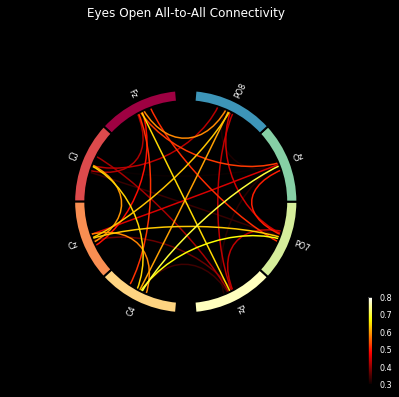

In [129]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black',
                       subplot_kw=dict(polar=True))
plot_connectivity_circle(conmat_EO, node_names = channels,
                         node_angles=node_angles, node_colors=None,
                         title='Eyes Open All-to-All Connectivity', ax=ax, vmin = 0.3, vmax = 0.8)
fig.tight_layout()

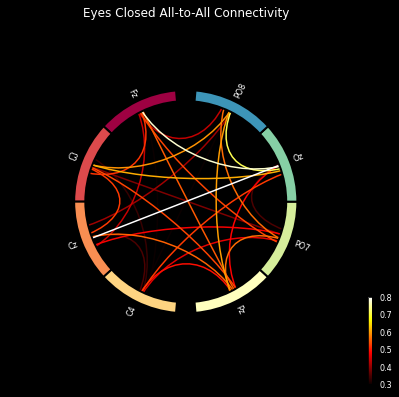

In [131]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black',
                       subplot_kw=dict(polar=True))
plot_connectivity_circle(conmat_EC, node_names = channels,
                         node_angles=node_angles, node_colors=None,
                         title='Eyes Closed All-to-All Connectivity', ax=ax, vmin = 0.3, vmax = 0.8)
fig.tight_layout()

# Phase lag index

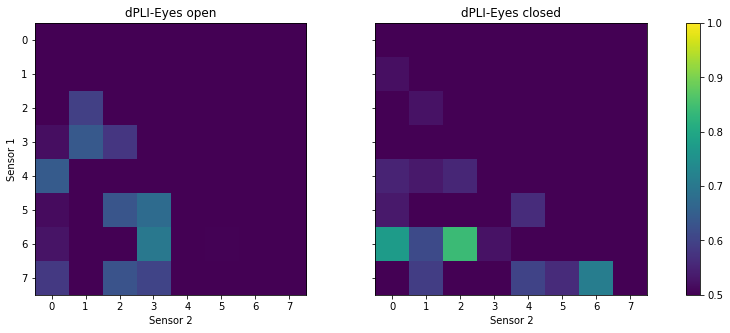

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs[0].imshow(con_EO.get_data('dense'), vmin=0.5, vmax=1)
axs[0].set_title("dPLI-Eyes open")
axs[0].set_ylabel("Sensor 1")
axs[0].set_xlabel("Sensor 2")

im = axs[1].imshow(con_EC.get_data('dense'), vmin=0.5, vmax=1)
axs[1].set_title("dPLI-Eyes closed")
axs[1].set_xlabel("Sensor 2")



fig.colorbar(im, ax=axs.ravel())
plt.show()